## Import Libraries

Import all the required Libraries

In [927]:
import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.decomposition import PCA

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from collections import Counter

In [928]:
import warnings
warnings.filterwarnings("ignore")

In [964]:
# Ablation Experiment (takes 15% of Total Data if ablation is true)
ablation = False
ablation_ratio = 0.15

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000
# Percentile of Padding to use with Tokenized words
pad_percentile = 50

# Use Keras Tokenizer
use_tokenizer = False
# Use TF IDF Vectorizer
use_tf_idf = True

# Text Column name
text_col = 'lower_text'

# How many PCA Components to consider for modelling
pca_components = 300

# Seed
numpy_seed = 478
seed = 7
# Number of Splits
n_splits = 10
# Scoring Criteria
scoring = 'neg_log_loss'

# if Debug is True, loads Subsequent Dataframes from Disk.
debug = False

## Create Train and Test DF

Create Training and Testing Data Frames

In [930]:
# TODO: Automate it to take path based on OS
ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants' # Mac Directory Path
#ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants' # Linux Directory Path

TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')

In [931]:
# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df

In [932]:
# Map target variable to number
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

# Util Functions

Some Utility Functions 

In [933]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [934]:
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [935]:
def get_tf_idf(train_df, test_df):
    """
        Get the TF IDF Vector representation for Train and Test data frame
        
        Creates the TF-IDF Vector, Fit on Training data and transform both training and test data frames
        Also, returns feature names for creating a Dataframe later
    """
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names()

In [936]:
def lemmatize(words):
    """
        Break a Sentence into words, remove Stop words keeping only alphabet and numbers, remove
        punctuations, comma etc. and at the end Lemmatize the words.
    """
    tokenized_words = nltk.word_tokenize(words)
    
    # Remove Stop words
    words = [word for word in tokenized_words if word.lower() not in stop_words]
    
    # Remove Digits, Keep only Alpha Numeric words
    words = [word for word in words if word.isalnum() and not word.isdigit()]

    # Lemmatize based on root word
    pos_tags = nltk.pos_tag(words)
    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tags])

In [937]:
def add_features(df):
    """
        Add few extra features to the Data Frame
        
        text: convert to string
        lower_text: lowers the text
        total_length: length of the document
        capitals: number of capitals in document
        caps_vs_length: ratio of capital words to total length
        num_words: number of words in document.
        num_unique_words: number of unique words in document
        words_vs_unique: number of unique words in document
        document_type: whether the docoment is pdf, doc or docx
    """
    df['text'] = df['text'].apply(lambda x:str(x))
    df["lower_text"] = df["text"].apply(lambda x: x.lower())
    df['total_length'] = df['text'].apply(len)
    df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.text.str.count('\S+')
    df['num_unique_words'] = df['text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    df['document_type'] = df['document_name'].apply(lambda val: val.split(".")[-1])
    return df

In [938]:
# Add derived features on Train and Test dataframe
train_df = add_features(train_df)
test_df = add_features(test_df)

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [939]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

# English Stop Words list
stop_words = set(nltk.corpus.stopwords.words('english'))

# Create a Tag Dictionary, Default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Get a Lemmatizer
lemma = WordNetLemmatizer()

In [940]:
%%time

# Caution: will take time to lemmatize whole Data
train_df[text_col] = train_df[text_col].apply(lemmatize)
test_df[text_col] = test_df[text_col].apply(lemmatize)

CPU times: user 7min 54s, sys: 495 ms, total: 7min 55s
Wall time: 7min 55s


In [941]:
train_df.to_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'), index = False)
test_df.to_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'), index = False)

In [966]:
if debug:
    train_df = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
    test_df = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

In [943]:
# Since, we have fetched document type from name and lower case text from text, we could safely remove these two columns
to_drop = ['document_name', 'text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [944]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

CPU times: user 1.6 s, sys: 353 ms, total: 1.95 s
Wall time: 2.09 s


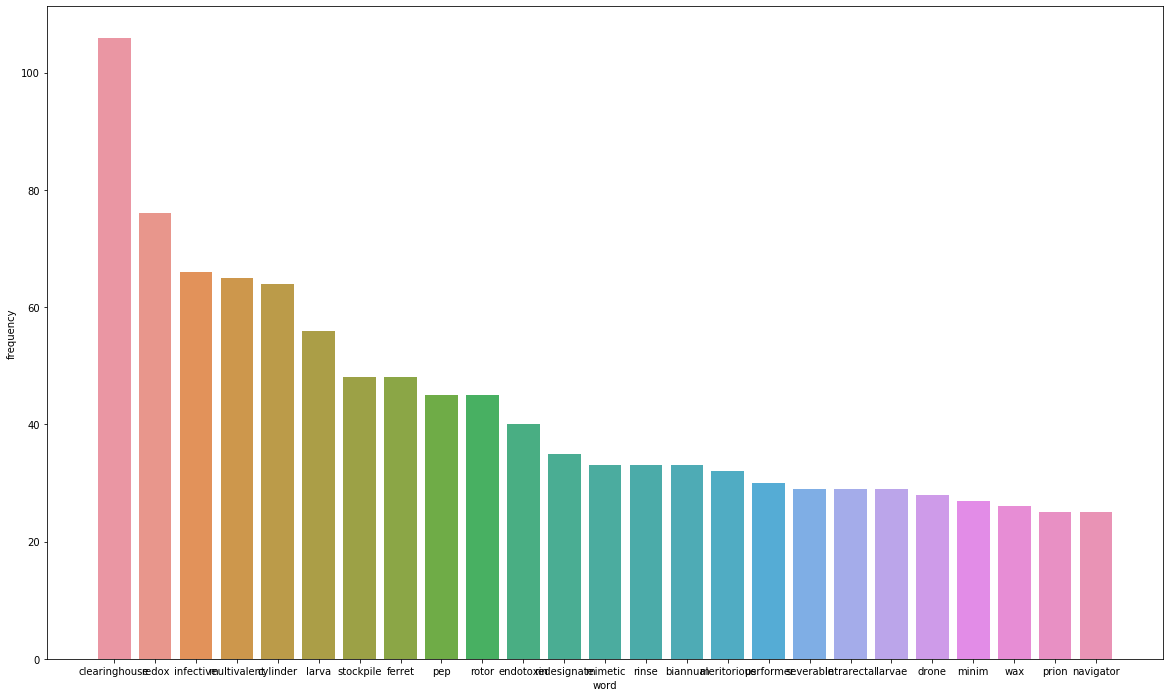

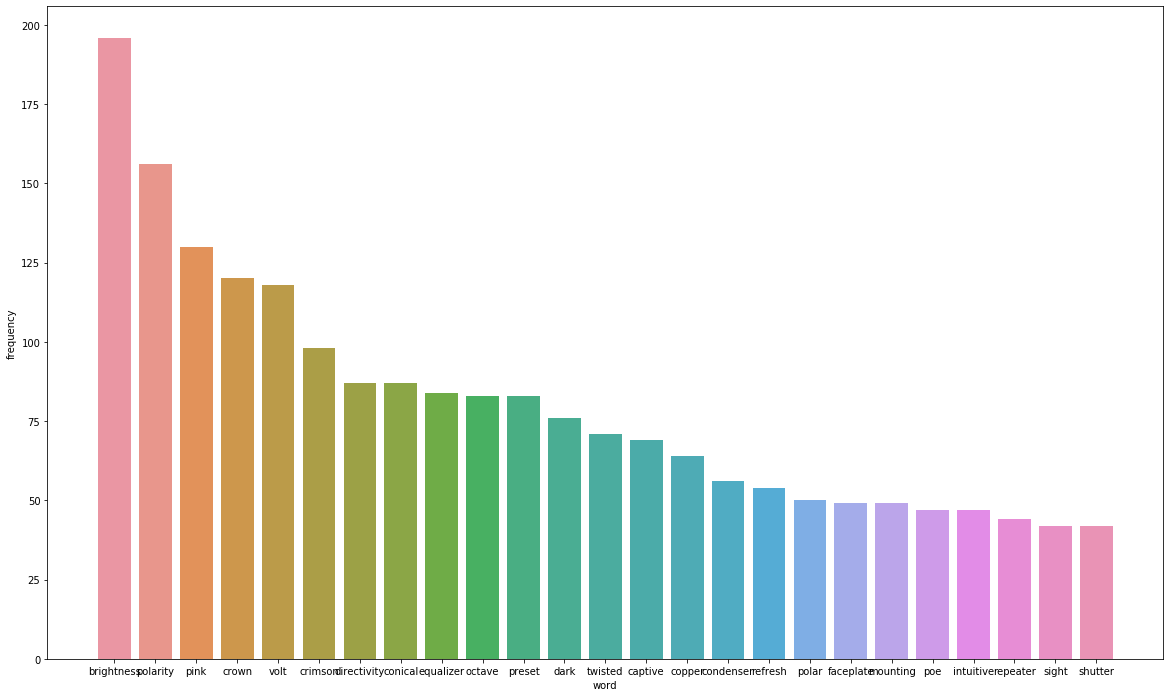

In [1057]:
%%time

def get_top_words_list(df):
    word_list = []

    df['lower_text'].map(lambda row: word_list.extend(row.split()))

    counter_df = pd.DataFrame.from_dict(Counter(word_list), orient='index').reset_index()

    counter_df.columns = ['word', 'frequency']

    return counter_df.sort_values(by = 'frequency', ascending = False)

def plot_top_words(df):
    # Segregated Positive and Negative classes
    top_counter_df_no = get_top_words_list(df[df.is_fitara == 0])
    top_counter_df_yes = get_top_words_list(df[df.is_fitara == 1])
    
    # Fetch Words in Negative class, which are not in Positive class
    exclusive_no = set(top_counter_df_no['word'].values) - set(top_counter_df_yes['word'].values)
    # Fetch Words in Positive class, which are not in Negative class
    exclusive_yes = set(top_counter_df_yes['word'].values) - set(top_counter_df_no['word'].values)
    
    # English Words Corpus
    english_words = set(nltk.corpus.words.words())
    
    # Keep valid english words only, remove random words
    exclusive_no = [word for word in exclusive_no if word in english_words]
    exclusive_yes = [word for word in exclusive_yes if word in english_words]
    
    # Get the Frequency of corresponding words from Original Dataframe
    exclusive_no_df = top_counter_df_no[top_counter_df_no['word'].isin(exclusive_no)]
    exclusive_yes_df = top_counter_df_yes[top_counter_df_yes['word'].isin(exclusive_yes)]
    
    # Plot top 25 words 
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_no_df.head(25))
    plt.plot()
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_yes_df.head(25))
    plt.plot()

#plot_top_words(train_df)

### Handle Categorical Variables

In [946]:
# Create dummies
train_df = pd.concat([train_df, pd.get_dummies(train_df['document_type'])], axis=1)
train_df.drop(['document_type'], axis=1, inplace=True)

### Ablation
If ablation is true, use only certain percentage of data for calculations

In [947]:
if ablation:
    train_df_no = train_df[train_df.is_fitara == 0]
    train_df_yes = train_df[train_df.is_fitara == 1]

    # Get 15% of total Records for Ablation
    train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation_ratio)]
    train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation_ratio)]
    
    # Shuffle rows and reset index
    train_df = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

### Train Test Split
Split into Test and training data sets

In [948]:
X = train_df.drop(['is_fitara'], axis=1)
y = train_df['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### TF IDF
Create TF IDF Vector representation for Train and Test datasets

In [949]:
if use_tf_idf:
    X_train_tf, X_test_tf, feature_names = get_tf_idf(X_train[text_col], X_test[text_col])

    X_train_df = pd.DataFrame(X_train_tf.toarray(), columns = feature_names, index = X_train.index)
    X_test_df = pd.DataFrame(X_test_tf.toarray(), columns = feature_names, index = X_test.index)

    X_train = pd.concat([X_train, X_train_df], axis=1)
    X_test = pd.concat([X_test, X_test_df], axis=1)

    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

### Tokenize the Strings
Tokenize the words into numbers

In [950]:
if use_tokenizer:
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train[text_col]))
    X_train[text_col] = tokenizer.texts_to_sequences(X_train[text_col])
    X_test[text_col] = tokenizer.texts_to_sequences(X_test[text_col])

### Pad the sentences 
if tokenizing the words, needs to handle length as well. All the vectors needs to be same length, so pad the ones that are shorter. <br/>

In [951]:
if use_tokenizer:
    # Find Length of all rows, take a number 50 percentile number
    train_max_len = np.percentile(X_train[text_col].apply(len), pad_percentile)
    test_max_len = np.percentile(X_test[text_col].apply(len), pad_percentile)

    # Get the maximum length
    max_len = int(test_max_len if train_max_len < test_max_len else train_max_len)

    # Pad the Sentences
    X_train_temp = pd.DataFrame(pad_sequences(X_train[text_col], maxlen=max_len), index = X_train.index)
    X_test_temp = pd.DataFrame(pad_sequences(X_test[text_col], maxlen=max_len), index = X_test.index)

    # Remove Existing DF
    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

    # Create new DF
    X_train = pd.concat([X_train_temp, X_train], axis = 1)
    X_test = pd.concat([X_test_temp, X_test], axis = 1)

### Standard Scaler Transformation

In [1062]:
# Scale the columns
scaler = StandardScaler()

if use_tokenizer:
    cols = X_train.columns
elif use_tf_idf:
    cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [953]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'), index = False)
X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'), index = False)

In [954]:
if debug:
    X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'))
    X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'))

### Principle Component Analysis

In [958]:
standard_columns = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique', 'doc', 'docx', 'pdf']

cols = X_train.columns[len(standard_columns):]

pca = PCA(n_components = pca_components)

pca.fit(X_train[cols])

X_train_pca = pd.DataFrame(pca.transform(X_train[cols]))
X_test_pca = pd.DataFrame(pca.transform(X_test[cols]))

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

Variance Explained by Model is 0.9001779821193537


In [959]:
# Remove Old Columns
X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

# Append PCA Columns
X_train = pd.concat([X_train, X_train_pca], axis=1)
X_test = pd.concat([X_test, X_test_pca], axis=1)

In [1063]:
# Save PCA Dataframe to Disk

X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pca.csv'), index = False)
y_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_label_pca.csv'), index = False)

X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pca.csv'), index = False)
y_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_label_pca.csv'), index = False)

In [1064]:
if debug:
    X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pca.csv'))
    y_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_label_pca.csv'))

    X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pca.csv'))
    y_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_label_pca.csv'))

### Model Building
First Try fitting a Simple Neural Network for benchmark

In [963]:
# fix random seed for reproducibility
np.random.seed(576)

# create model
model = Sequential()
model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(18, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#model = Sequential()
#model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(18, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
# Compile model
#sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# train model
history = model.fit(X_train, to_categorical(y_train, 2), epochs=400, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/400
 - 2s - loss: 0.7590 - acc: 0.4930
Epoch 2/400
 - 0s - loss: 0.5921 - acc: 0.7221
Epoch 3/400
 - 0s - loss: 0.5805 - acc: 0.7221
Epoch 4/400
 - 0s - loss: 0.5780 - acc: 0.7221
Epoch 5/400
 - 0s - loss: 0.5733 - acc: 0.7221
Epoch 6/400
 - 0s - loss: 0.5671 - acc: 0.7193
Epoch 7/400
 - 0s - loss: 0.5590 - acc: 0.7207
Epoch 8/400
 - 0s - loss: 0.5493 - acc: 0.7151
Epoch 9/400
 - 0s - loss: 0.5465 - acc: 0.7095
Epoch 10/400
 - 0s - loss: 0.5308 - acc: 0.7095
Epoch 11/400
 - 0s - loss: 0.5234 - acc: 0.7221
Epoch 12/400
 - 0s - loss: 0.5084 - acc: 0.7318
Epoch 13/400
 - 0s - loss: 0.4880 - acc: 0.7528
Epoch 14/400
 - 0s - loss: 0.4779 - acc: 0.7458
Epoch 15/400
 - 0s - loss: 0.4593 - acc: 0.7821
Epoch 16/400
 - 0s - loss: 0.4361 - acc: 0.8059
Epoch 17/400
 - 0s - loss: 0.4038 - acc: 0.8226
Epoch 18/400
 - 0s - loss: 0.3927 - acc: 0.8198
Epoch 19/400
 - 0s - loss: 0.3709 - acc: 0.8520
Epoch 20/400
 - 0s - loss: 0.3473 - acc: 0.8561
Epoch 21/400
 - 0s - loss: 0.3438 - acc: 0.8506
E

Epoch 171/400
 - 0s - loss: 0.1202 - acc: 0.9455
Epoch 172/400
 - 0s - loss: 0.1261 - acc: 0.9372
Epoch 173/400
 - 0s - loss: 0.1292 - acc: 0.9344
Epoch 174/400
 - 0s - loss: 0.1056 - acc: 0.9525
Epoch 175/400
 - 0s - loss: 0.1158 - acc: 0.9455
Epoch 176/400
 - 0s - loss: 0.1130 - acc: 0.9469
Epoch 177/400
 - 0s - loss: 0.1111 - acc: 0.9483
Epoch 178/400
 - 0s - loss: 0.1205 - acc: 0.9483
Epoch 179/400
 - 0s - loss: 0.1173 - acc: 0.9441
Epoch 180/400
 - 0s - loss: 0.1186 - acc: 0.9399
Epoch 181/400
 - 0s - loss: 0.1100 - acc: 0.9483
Epoch 182/400
 - 0s - loss: 0.1071 - acc: 0.9455
Epoch 183/400
 - 0s - loss: 0.1132 - acc: 0.9469
Epoch 184/400
 - 0s - loss: 0.1039 - acc: 0.9469
Epoch 185/400
 - 0s - loss: 0.1055 - acc: 0.9469
Epoch 186/400
 - 0s - loss: 0.1017 - acc: 0.9581
Epoch 187/400
 - 0s - loss: 0.1069 - acc: 0.9539
Epoch 188/400
 - 0s - loss: 0.1023 - acc: 0.9525
Epoch 189/400
 - 0s - loss: 0.1185 - acc: 0.9344
Epoch 190/400
 - 0s - loss: 0.1061 - acc: 0.9511
Epoch 191/400
 - 0s 

 - 0s - loss: 0.0696 - acc: 0.9763
Epoch 339/400
 - 0s - loss: 0.0795 - acc: 0.9693
Epoch 340/400
 - 0s - loss: 0.0874 - acc: 0.9609
Epoch 341/400
 - 0s - loss: 0.0758 - acc: 0.9665
Epoch 342/400
 - 0s - loss: 0.0787 - acc: 0.9623
Epoch 343/400
 - 0s - loss: 0.0712 - acc: 0.9735
Epoch 344/400
 - 0s - loss: 0.0844 - acc: 0.9581
Epoch 345/400
 - 0s - loss: 0.0852 - acc: 0.9609
Epoch 346/400
 - 0s - loss: 0.0721 - acc: 0.9707
Epoch 347/400
 - 0s - loss: 0.0798 - acc: 0.9581
Epoch 348/400
 - 0s - loss: 0.0825 - acc: 0.9637
Epoch 349/400
 - 0s - loss: 0.0791 - acc: 0.9679
Epoch 350/400
 - 0s - loss: 0.0871 - acc: 0.9609
Epoch 351/400
 - 0s - loss: 0.0843 - acc: 0.9609
Epoch 352/400
 - 0s - loss: 0.0710 - acc: 0.9721
Epoch 353/400
 - 0s - loss: 0.0870 - acc: 0.9637
Epoch 354/400
 - 0s - loss: 0.0776 - acc: 0.9637
Epoch 355/400
 - 0s - loss: 0.0755 - acc: 0.9665
Epoch 356/400
 - 0s - loss: 0.0732 - acc: 0.9665
Epoch 357/400
 - 0s - loss: 0.0821 - acc: 0.9609
Epoch 358/400
 - 0s - loss: 0.0871

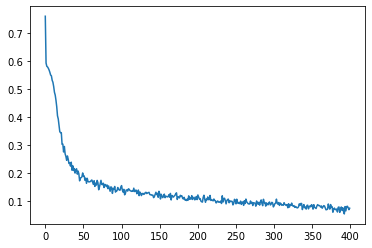

In [970]:
# plot metrics
plt.plot(history.history['loss'])
plt.show()

In [972]:
y_pred = model.predict(X_test)

num_train = metrics.log_loss(y_train.values, model.predict(X_train))
num_test = metrics.log_loss(y_test.values, y_pred)

print(f"Log Loss on Train is {num_train} and exponential is {math.exp(-num_train)}.\
      \nLog Loss on Test is {num_test} and exponential is {math.exp(-num_test)}.\
      \nAccuracy Score is ")#{metrics.accuracy_score(y_test, y_pred)}")

Log Loss on Train is 0.05092498288675312 and exponential is 0.9503499603690158.      
Log Loss on Test is 0.8520017526523118 and exponential is 0.42656020873270023.      
Accuracy Score is 


Let's check cross validation score for different algorithms on training Data

LR :: -0.391622 ( +- 0.049526) 
 Log Loss : 0.480177
 Accuracy : 79.920000

NB :: -0.734945 ( +- 0.181946) 
 Log Loss : 0.719681
 Accuracy : 74.060000

LDA :: -2.819043 ( +- 1.112494) 
 Log Loss : 0.953290
 Accuracy : 82.430000

KNN :: -1.112794 ( +- 0.642292) 
 Log Loss : 1.254520
 Accuracy : 79.080000

TREE :: -6.077455 ( +- 1.120105) 
 Log Loss : 7.520513
 Accuracy : 77.410000

CART :: -0.416959 ( +- 0.048960) 
 Log Loss : 0.437220
 Accuracy : 79.500000

NB :: -2.616009 ( +- 0.670128) 
 Log Loss : 1.451151
 Accuracy : 75.310000

SVM :: -0.364224 ( +- 0.065598) 
 Log Loss : 0.495614
 Accuracy : 68.620000

XGB :: -0.364698 ( +- 0.105507) 
 Log Loss : 0.381285
 Accuracy : 86.610000



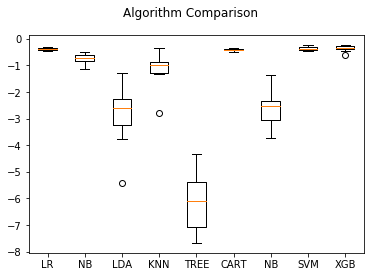

In [1067]:
"""
If we use sklearn.metrics.log_loss standalone, i.e. log_loss(y_true,y_pred), 
it generates a positive score -- the smaller the score, the better the performance.

However, if we use 'neg_log_loss' as a scoring scheme as in 'cross_val_score", 
the score is negative -- the bigger the score, the better the performance.
"""

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost.sklearn import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict


estimators = []

estimators.append(('LR', LogisticRegression()))
estimators.append(('NB', BernoulliNB(alpha=.01)))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('TREE', DecisionTreeClassifier()))
estimators.append(('CART', RandomForestClassifier(n_estimators=100)))
estimators.append(('NB', GaussianNB()))
estimators.append(('SVM', SVC(probability=True)))
estimators.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_log_loss')
    #cv_results = model_selection.cross_val_predict(model, X_train, y_train, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    
    model.fit(X_train, y_train)
    
    log_loss = metrics.log_loss(y_test, model.predict_proba(X_test))
    accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    msg = "%s :: %f ( +- %f) \n Log Loss : %f\n Accuracy : %f\n" % (name, cv_results.mean(), cv_results.std(), log_loss, round(accuracy*100, 2))
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [1099]:

pd.DataFrame(metrics.confusion_matrix(y_test.values, estimators[-1][1].predict(X_test)), 
             columns = ["Prediction No","Prediction Yes"], index=["Actual No", "Actual Yes"])

#print(metrics.accuracy_score(y_test.values, estimators[2][1].predict(X_test)))
#print(metrics.log_loss(y_test.values, estimators[4][1].predict_proba(X_test)))
#math.exp(-metrics.log_loss(y_test.values, estimators[5][1].predict_proba(X_test)))

#y_pred = estimators[2][1].predict(X_test)
#metrics.roc_curve(y_test.values, y_pred)
#estimators[2][1].predict_proba(X_test)

,Prediction No,Prediction Yes
Actual No,156,8
Actual Yes,24,51


In [1089]:
%%time
from sklearn.model_selection import GridSearchCV

# XGBClassifier with early stopping Returns the model from the last iteration (not the best one).
# In order to provide to GridSearchCV the score of the best model, we need to use a score function
# to evaluate log_loss calling the estimator with the appropiate  ntree_limit param 
#(instead of using scoring=‘neg_log_loss’ in GridSearchCV creation)
#in order to use the best iteration of the estimator (ntree_limit)

def score_func(estimator, X, y):
    score = metrics.log_loss(y, estimator.predict_proba(X))
    return -score

fit_params={
    "eval_metric": 'mlogloss',
    "early_stopping_rounds":100,
    "verbose":True
}

tuning_parameters = {
    'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
    'max_depth': [3, 5, 10, 15, 20, 25], 
    'n_estimators': [3, 5, 10, 15, 20, 25]
}

xgb_model = XGBClassifier(seed = 0)

grid_search = GridSearchCV(xgb_model, tuning_parameters, n_jobs=7, scoring = score_func,
                cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True), verbose=2, refit=True)
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 504 candidates, totalling 5040 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 tasks      | elapsed:    1.8s
[Parallel(n_jobs=7)]: Done 207 tasks      | elapsed:   16.8s
[Parallel(n_jobs=7)]: Done 410 tasks      | elapsed:   42.8s
[Parallel(n_jobs=7)]: Done 693 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 1058 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 1503 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 2030 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done 2637 tasks      | elapsed:  4.9min
[Parallel(n_jobs=7)]: Done 3326 tasks      | elapsed:  6.1min
[Parallel(n_jobs=7)]: Done 4095 tasks      | elapsed:  7.5min
[Parallel(n_jobs=7)]: Done 4946 tasks      | elapsed:  8.9min
[Parallel(n_jobs=7)]: Done 5040 out of 5040 | elapsed:  9.1min finished


CPU times: user 41.4 s, sys: 1.53 s, total: 42.9 s
Wall time: 9min 6s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objec...
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=7,
             param_grid={'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,
                                           0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
                                           0.7

In [1094]:
print (grid_search.best_params_)
print (grid_search.best_score_)

#metrics.log_loss(y_test, grid_search.predict_proba(X_test))

#metrics.confusion_matrix(y_test.values, y_pred)

{'learning_rate': 0.15, 'max_depth': 20, 'n_estimators': 25}
-0.3219297190441349


In [1102]:
xgb_model2 = XGBClassifier(seed = 0, learning_rate= 0.25, max_depth= 20, n_estimators= 25)

xgb_model2.fit(X_train, y_train)

print(metrics.log_loss(y_test, xgb_model2.predict_proba(X_test)))
print(metrics.accuracy_score(y_test, xgb_model2.predict(X_test)))

pd.DataFrame(metrics.confusion_matrix(y_test.values, xgb_model2.predict(X_test)), 
             columns = ["Prediction No","Prediction Yes"], index=["Actual No", "Actual Yes"])


0.43687030514039754
0.8158995815899581


,Prediction No,Prediction Yes
Actual No,153,11
Actual Yes,33,42
